In [1]:
from IPython.display import Markdown
import wandb
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

api = wandb.Api()


In [2]:
projects = api.projects(entity="haraghi")
for project in projects:
    print(project.name)

Subsamplimg_methods_NCALTECH101
Subsamplimg_methods_DVS_GESTURE_TONIC
Subsamplimg_acc_comparision_DVS_GESTURE_TONIC
Subsamplimg-vs-bandwidth-NASL
Subsamplimg-vs-bandwidth-FAN1VS3
Subsamplimg-vs-bandwidth-NCALTECH101
Subsamplimg-vs-bandwidth-DVS_GESTURE_TONIC
Subsamplimg-vs-bandwidth-NCARS
FINAL-NASL-HP-sweep-reduced
FINAL-NCALTECH101-HP-sweep-reduced
FINAL-DVSGESTURE_TONIC-HP-sweep-reduced
FINAL-FAN1vs3-HP-sweep-reduced
FINAL-DVSGESTURE_TONIC-HP-varyinig-sparsity
FINAL-NCARS-varyinig-sparsity
FINAL-NASL-varyinig-sparsity
FINAL-NCALTECH101-varyinig-sparsity
FINAL-FAN1vs3-varyinig-sparsity
lightning_logs
FINAL-FAN1vs3-HP-sweep
EST-DVSGESTURE-HP-sweep-InMemory
EST-NASL-HP-sweep
EST-DVSGESTURE-HP-sweep
sweep_EST_NCALTECH101_HP_sweep
sweep_EST_FAN1VS3_25000_initialization_effect_multi20
sweep_EST_FAN1VS3_1024_initialization_effect_multi20
sweep_EST_NCALTECH101_25000_initialization_effect_multi20
sweep_EST_NCALTECH101_256_initialization_effect_multi20
sweep_EST_NCALTECH101_1024_multi20
sweep

In [3]:
datasets_name_and_num_classes = {
    "NCARS": {"name": "N-Cars", "num_classes": 2},
    "NASL": {"name": "N-ASL", "num_classes": 24},
    "NCALTECH101": {"name": "N-Caltech101", "num_classes": 101},
    "DVSGESTURE_TONIC": {"name": "DVS-Gesture", "num_classes": 11},
    "FAN1VS3": {"name": "Fan1vs3", "num_classes": 2}
}

In [4]:
dataset_projects = [
        "FINAL-NASL-varyinig-sparsity",
        "FINAL-NCARS-varyinig-sparsity",
        "FINAL-DVSGESTURE_TONIC-HP-varyinig-sparsity",
        "FINAL-FAN1VS3-varyinig-sparsity",
        "FINAL-NCALTECH101-varyinig-sparsity",
]

In [5]:
def find_val_and_test_acc_keys(run):
    val_acc_key = []
    test_acc_key = []
    for key in run.summary.keys():
        if "val" in key and "acc" in key and "mean" in key:
            val_acc_key.append(key)
        if "test" in key and "acc" in key and "mean" in key:
            test_acc_key.append(key)
    assert len(val_acc_key) <= 1, f"More than one val acc key found: {val_acc_key}"
    assert len(test_acc_key) <= 1, f"More than one test acc key found: {test_acc_key}"
    return val_acc_key[0] if len(val_acc_key) == 1 else None , test_acc_key[0] if len(test_acc_key) == 1 else None

In [6]:
folder_name = 'paper'
subfolder_name = os.path.join('images',folder_name,'sparsity_vs_acc')
entity = 'haraghi'
if not os.path.exists(subfolder_name):
    os.makedirs(subfolder_name)
file_path = os.path.join(subfolder_name,"sparsity_vs_acc.tex")
file_path_md = os.path.join(subfolder_name,"sparsity_vs_acc.md")


val_dict = {}
test_dict = {}
num_events_set = set() 

for project_name in dataset_projects:
    runs = api.runs(f"{entity}/{project_name}")
    runs = [r for r in runs if r.state == "finished" and "transform" in r.config]
    if len(runs) == 0:
        print(f"No runs found for {project_name}")
        continue
    num_events = np.unique([run.config['transform']['train']['num_events_per_sample'] for run in runs])
    runs_per_num_events = {num_event: [run for run in runs if run.config['transform']['train']['num_events_per_sample'] == num_event] for num_event in num_events}
    dataset_name = runs[0].config["dataset"]["name"]
    
    num_events_set = num_events_set.union(set(num_events))
    
    val_mean = {}
    test_mean = {}
    lr = {}
    batch_size = {}
    weight_decay = {}
    
    for num_event in num_events:
        val_mean[num_event] = []
        test_mean[num_event] = []
        lr[num_event] = []
        batch_size[num_event] = []
        weight_decay[num_event] = []
        for run in runs_per_num_events[num_event]:
            val_key, test_key = find_val_and_test_acc_keys(run)
            val_mean[num_event].append(run.summary[val_key] if val_key in run.summary else None)
            test_mean[num_event].append(run.summary[test_key] if test_key in run.summary else None)
            lr[num_event].append(run.config['optimize']['lr'])
            batch_size[num_event].append(run.config['train']['batch_size'])
            if 'weight_decay' in run.config['optimize']:
                weight_decay[num_event].append(run.config['optimize']['weight_decay'])
                
        print(f"percentage of runs with val acc for {num_event} events: {np.sum([v is not None for v in val_mean[num_event]]) / len(val_mean[num_event])} out of {len(val_mean[num_event])} runs")
        print(f"percentage of runs with test acc for {num_event} events: {np.sum([v is not None for v in test_mean[num_event]]) / len(test_mean[num_event])} out of {len(test_mean[num_event])} runs")
    
    val_dict[dataset_name] = val_mean
    test_dict[dataset_name] = test_mean  

num_events_list = sorted(list(num_events_set))

percentage of runs with val acc for 8 events: 1.0 out of 3 runs
percentage of runs with test acc for 8 events: 1.0 out of 3 runs
percentage of runs with val acc for 16 events: 1.0 out of 3 runs
percentage of runs with test acc for 16 events: 1.0 out of 3 runs
percentage of runs with val acc for 32 events: 1.0 out of 3 runs
percentage of runs with test acc for 32 events: 1.0 out of 3 runs
percentage of runs with val acc for 64 events: 1.0 out of 3 runs
percentage of runs with test acc for 64 events: 1.0 out of 3 runs
percentage of runs with val acc for 512 events: 1.0 out of 3 runs
percentage of runs with test acc for 512 events: 1.0 out of 3 runs
percentage of runs with val acc for 1024 events: 1.0 out of 3 runs
percentage of runs with test acc for 1024 events: 1.0 out of 3 runs
percentage of runs with val acc for 4096 events: 1.0 out of 3 runs
percentage of runs with test acc for 4096 events: 1.0 out of 3 runs
percentage of runs with val acc for 25000 events: 1.0 out of 3 runs
percent

In [7]:
def create_full_metric_mean_std(metric_dict, num_events_list):
    full_metric_mean_std = {}
    for dataset_name, num_events_dict in metric_dict.items():
        full_metric_mean_std[dataset_name] = []
        for num_events in num_events_list:
            if num_events in num_events_dict and not any([v is None for v in num_events_dict[num_events]]):
                full_metric_mean_std[dataset_name].append((np.mean(num_events_dict[num_events]), np.std(num_events_dict[num_events])))
            else:
                full_metric_mean_std[dataset_name].append((None, None))
    return full_metric_mean_std


In [8]:
full_test_mean_std = create_full_metric_mean_std(test_dict, num_events_list)
full_val_mean_std = create_full_metric_mean_std(val_dict, num_events_list)

In [9]:
def write_sparsity_vs_acc_table(file_path, full_metric_mean_std, num_events_list, datasets_name_and_num_classes):
    # Open file for writing
    with open(file_path, "w") as file:
        # Write table header
        file.write("\\begin{tabular}{"+("c"*(3+len(num_events_list)))+"}\n")
        file.write("\\toprule\n")
        file.write(" & & & \\multicolumn{"+str(len(num_events_list))+"}{c}{\\# events per video}\\\\\n")
        file.write("Dataset & \\# classes & & " +
                   " & ".join([str(num_events) for num_events in num_events_list]) +
                   "\\\\\n")
        file.write("\\midrule\n")

        # Write table rows
        for dataset, values in full_metric_mean_std.items():
            row = datasets_name_and_num_classes[dataset]["name"] + " & " 
            # Number of classes
            row += str(datasets_name_and_num_classes[dataset]["num_classes"]) + " & "
            # Test accuracies
            row += "Test Acc. (\\%) & "
            
            
            # for mean_std_tuple in values:
            #     if mean_std_tuple[0] is not None:
            #         row += "${:.2f}$ \\textcolor{{WildStrawberry}}{{\\scriptsize $\\pm {:.2f}$}}".format(mean_std_tuple[0] * 100, mean_std_tuple[1] * 100) + " & "
            #     else:
            #         row += "-- & "
            # file.write(row[:-2] + "\\\\\n")
            
            for mean_std_tuple in values:
                if mean_std_tuple[0] is not None:
                    row += "${:.2f}$".format(mean_std_tuple[0] * 100) + " & "
                else:
                    row += "-- & "
            file.write(row[:-2] + "\\\\\n")
            
            row =  " & & "
            row += "\\textcolor{WildStrawberry}{\\scriptsize Std. Dev. (\\%)} & "
            for mean_std_tuple in values:
                if mean_std_tuple[1] is not None:
                    row += "\\textcolor{{WildStrawberry}}{{\\scriptsize$\\pm {:.2f}$}}".format(mean_std_tuple[1] * 100) + " & "
                else:
                    row += "-- & "                    
            # Write the row
            file.write(row[:-2] + "\\\\\n")
            
            row =  " & & "
            row += "\\textcolor{Cerulean}{\\scriptsize p-value} & "
            for mean_std_tuple in values:
                if mean_std_tuple[2] is not None:
                    row += r"\textcolor{Cerulean}{\scriptsize " +  mean_std_tuple[2] + "} & "
                else:
                    row += "-- & "                    
            # Write the row
            file.write(row[:-2] + "\\\\\n")
            
        # Write table footer
        file.write("\\bottomrule\n")
        file.write("\\end{tabular}\n")


In [10]:
def write_sparsity_vs_acc_table_md(file_path, full_metric_mean_std, num_events_list, datasets_name_and_num_classes):
    # Open file for writing
    with open(file_path, "w") as file:
        # Write table header
  


        file.write("| Dataset | # classes | " +
                   " | ".join([str(num_events) for num_events in num_events_list]) +
                   "\n")
        file.write("| --- "*(2+len(num_events_list))+"|\n")
        # Write table rows
        for dataset, values in full_metric_mean_std.items():
            row = "| " + datasets_name_and_num_classes[dataset]["name"] + " | " 
            # Number of classes
            row += str(datasets_name_and_num_classes[dataset]["num_classes"]) + " | "
            # Test accuracies
            for mean_std_tuple in values:
                if mean_std_tuple[0] is not None:
                    row += "${:.2f}$".format(mean_std_tuple[0] * 100) + " ($\\pm {:.2f}$)".format(mean_std_tuple[1] * 100) + " | "
                else:
                    row += "-- | "
            # Write the row
            file.write(row[:-2] + "|\n")



In [11]:
import pickle
with open(os.path.join(subfolder_name,"full_val_mean_std.pickle"), "wb") as f:
    pickle.dump([full_val_mean_std,num_events_list], f)
with open(os.path.join(subfolder_name,"full_test_mean_std.pickle"), "wb") as f:
    pickle.dump([full_test_mean_std,num_events_list], f)
with open(os.path.join(subfolder_name,"p_values_text.pkl"), "rb") as f:
    p_values_text = pickle.load(f)

In [12]:
full_test_mean_std_p_value = {}
for dataset_name in full_test_mean_std.keys():
    full_test_mean_std_p_value[dataset_name] = []
    for i, (mean, std) in enumerate(full_test_mean_std[dataset_name]):       
            full_test_mean_std_p_value[dataset_name].append((mean, std, p_values_text[dataset_name][i]))
print(full_test_mean_std_p_value)

{'NASL': [(0.24331018949548402, 0.28515998820574484, '0'), (0.9143540859222412, 0.0036633454101364705, '0'), (0.9799338976542155, 0.002334424741491835, '0'), (0.9914814631144205, 0.0007700486211130599, '0'), (0.9979673425356547, 7.652945994118014e-05, '0'), (0.9978968103726705, 0.0009114670746096208, '0'), (0.9981085062026978, 0.0014913608287696431, '0'), (0.9976124366124471, 0.002754861421841336, '0')], 'NCARS': [(0.7250532507896423, 0.0018450432832934148, '0'), (0.7874055902163187, 0.0012296168691552818, '0'), (0.8323283195495605, 0.00171698718788872, '0'), (0.8658378521601359, 0.001644895867676298, '0'), (0.9296502669652303, 0.0013166511368499342, '0'), (0.9323322375615438, 0.0020437756458028806, '0'), (0.9246156016985575, 0.009506995269258516, '0'), (0.9186863303184509, 0.008144368215586041, '0')], 'DVSGESTURE_TONIC': [(0.47980518341064454, 0.0020815876410716157, '1.08e-205'), (0.5598809361457825, 0.0023429251141913214, '3.25e-282'), (0.7523268222808838, 0.022068741841838033, '0'),

In [13]:
# write_sparsity_vs_acc_table(file_path, full_test_mean_std_p_value, num_events_list, datasets_name_and_num_classes)
write_sparsity_vs_acc_table_md(file_path_md, full_test_mean_std, num_events_list, datasets_name_and_num_classes)

# Display the content of the Markdown file as a Markdown cell
with open(file_path_md, "r") as file:
    markdown_content = file.read()

Markdown(markdown_content)

| Dataset | # classes | 8 | 16 | 32 | 64 | 512 | 1024 | 4096 | 25000
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| N-ASL | 24 | $24.33$ ($\pm 28.52$) | $91.44$ ($\pm 0.37$) | $97.99$ ($\pm 0.23$) | $99.15$ ($\pm 0.08$) | $99.80$ ($\pm 0.01$) | $99.79$ ($\pm 0.09$) | $99.81$ ($\pm 0.15$) | $99.76$ ($\pm 0.28$) |
| N-Cars | 2 | $72.51$ ($\pm 0.18$) | $78.74$ ($\pm 0.12$) | $83.23$ ($\pm 0.17$) | $86.58$ ($\pm 0.16$) | $92.97$ ($\pm 0.13$) | $93.23$ ($\pm 0.20$) | $92.46$ ($\pm 0.95$) | $91.87$ ($\pm 0.81$) |
| DVS-Gesture | 11 | $47.98$ ($\pm 0.21$) | $55.99$ ($\pm 0.23$) | $75.23$ ($\pm 2.21$) | $84.81$ ($\pm 0.34$) | $93.37$ ($\pm 0.65$) | $94.69$ ($\pm 0.30$) | $95.18$ ($\pm 0.49$) | $95.33$ ($\pm 0.52$) |
| Fan1vs3 | 2 | $53.35$ ($\pm 0.56$) | $54.17$ ($\pm 1.77$) | $56.62$ ($\pm 0.42$) | $58.53$ ($\pm 0.99$) | $75.29$ ($\pm 1.19$) | $94.00$ ($\pm 5.69$) | $98.24$ ($\pm 0.79$) | $99.40$ ($\pm 0.51$) |
| N-Caltech101 | 101 | $25.20$ ($\pm 0.17$) | $31.37$ ($\pm 0.15$) | $39.00$ ($\pm 0.21$) | $46.19$ ($\pm 0.19$) | $67.85$ ($\pm 0.42$) | $74.06$ ($\pm 0.54$) | $82.87$ ($\pm 0.47$) | $88.62$ ($\pm 0.51$) |


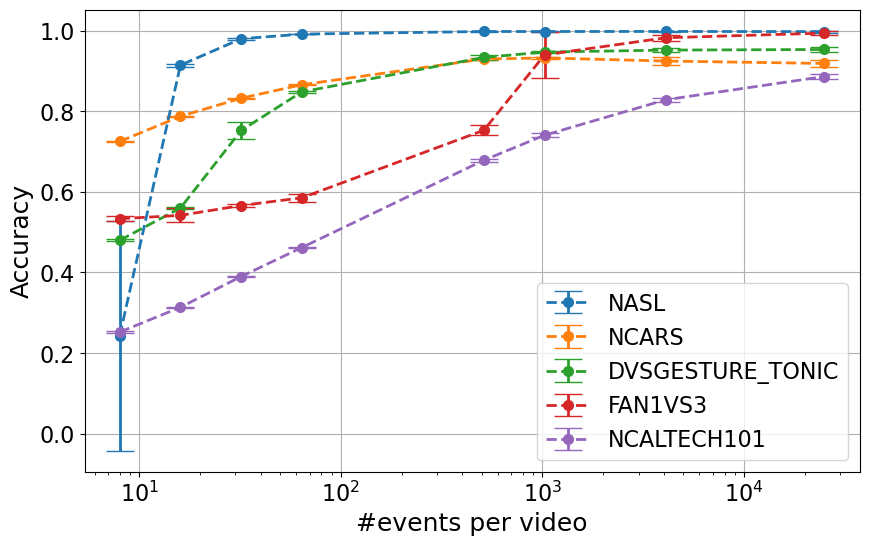

In [26]:

plt.figure(figsize=(10, 6))  # Increase figure size for better visibility

for dataset, sparsity_data in test_dict.items():
    sparsities = []
    mean_accuracies = []
    std_accuracies = []
    
    for sparsity, accuracies in sparsity_data.items():
        sparsities.append(sparsity)
        mean_accuracies.append(np.mean(accuracies))
        std_accuracies.append(np.std(accuracies))
    
    plt.errorbar(sparsities, mean_accuracies, yerr=std_accuracies, label=dataset, capsize=10, marker='o', linestyle='--', markersize=7, linewidth=2)

plt.xlabel('#events per video', fontsize=18)  # Increase label font size
plt.ylabel('Accuracy', fontsize=18)  # Increase label font size
# plt.title('Accuracy vs Sparsity', fontsize=20)  # Increase title font size
plt.xscale('log')  # Log scale if sparsity values span several orders of magnitude

plt.xticks(fontsize=16)  # Increase tick font size
plt.yticks(fontsize=16)  # Increase tick font size

plt.legend(fontsize=16)  # Increase legend font size
plt.grid(True)
plt.savefig(os.path.join(subfolder_name,"sparsity_vs_acc_curves.png"))
plt.show()


In [15]:
def write_sparsity_vs_acc_table_wo_p_value(file_path, full_metric_mean_std, num_events_list, datasets_name_and_num_classes):
    # Open file for writing
    with open(file_path, "w") as file:
        # Write table header
        file.write("\\begin{tabular}{"+("c"*(3+len(num_events_list)))+"}\n")
        file.write("\\toprule\n")
        file.write(" & & & \\multicolumn{"+str(len(num_events_list))+"}{c}{\\# events per video}\\\\\n")
        file.write("Dataset & \\# classes & & " +
                   " & ".join([str(num_events) for num_events in num_events_list]) +
                   "\\\\\n")
        file.write("\\midrule\n")

        # Write table rows
        for dataset, values in full_metric_mean_std.items():
            row = datasets_name_and_num_classes[dataset]["name"] + " & " 
            # Number of classes
            row += str(datasets_name_and_num_classes[dataset]["num_classes"]) + " & "
            # Test accuracies
            row += "Test Acc. (\\%) & "
            
            
            # for mean_std_tuple in values:
            #     if mean_std_tuple[0] is not None:
            #         row += "${:.2f}$ \\textcolor{{WildStrawberry}}{{\\scriptsize $\\pm {:.2f}$}}".format(mean_std_tuple[0] * 100, mean_std_tuple[1] * 100) + " & "
            #     else:
            #         row += "-- & "
            # file.write(row[:-2] + "\\\\\n")
            
            for mean_std_tuple in values:
                if mean_std_tuple[0] is not None:
                    row += "${:.2f}$".format(mean_std_tuple[0] * 100) + " & "
                else:
                    row += "-- & "
            file.write(row[:-2] + "\\\\\n")
            
            row =  " & & "
            row += "\\textcolor{WildStrawberry}{\\scriptsize Std. Dev. (\\%)} & "
            for mean_std_tuple in values:
                if mean_std_tuple[1] is not None:
                    row += "\\textcolor{{WildStrawberry}}{{\\scriptsize$\\pm {:.2f}$}}".format(mean_std_tuple[1] * 100) + " & "
                else:
                    row += "-- & "                    
            # Write the row
            file.write(row[:-2] + "\\\\\n")
            
            # row =  " & & "
            # row += "\\textcolor{Cerulean}{\\scriptsize p-value} & "
            # for mean_std_tuple in values:
            #     if mean_std_tuple[2] is not None:
            #         row += r"\textcolor{Cerulean}{\scriptsize " +  mean_std_tuple[2] + "} & "
            #     else:
            #         row += "-- & "                    
            # # Write the row
            # file.write(row[:-2] + "\\\\\n")
            
        # Write table footer
        file.write("\\bottomrule\n")
        file.write("\\end{tabular}\n")

In [16]:
file_path = os.path.join(subfolder_name,"sparsity_vs_acc_wo_p_value.tex")
write_sparsity_vs_acc_table_wo_p_value(file_path, full_test_mean_std_p_value, num_events_list, datasets_name_and_num_classes)

In [17]:
file_path

'images/paper/sparsity_vs_acc/sparsity_vs_acc_wo_p_value.tex'